In [1]:
from utils import *

# Load env 
env = read_env(jupyter=True)
patientNr, path, maxPatient = env.patientNr, env.path, env.maxPatient

path_to_ISF = 'simulations/calculate_ISF/ISF.npz' ##TODO update this
dat = np.load(path_to_ISF)
all_ISF = dat['all_ISF']

In [2]:
patientNr = patientNr + 1
files_to_save = dict()

patient = Sim.Patient(patientNr, ISF=all_ISF[patientNr])

patient.steadyState() # compute the basal insulin and steady-state 


In [3]:
path_to_u_opt = 'simulations/calculate_u_opt/data/'
patient.set_u_opt(path_to_u_opt=path_to_u_opt)
patient.estimate_ICR(patient.u_opt[-75:],patient.u_opt_meal_range[-75:])
true_ICR = patient.ICR.copy()
patient.ICR = 0.024226699349986853 ##  mean is 0.024226699349986853 median is 0.02301168185491187
patient.ISF = 3.9051998090152185   ## mean ISF is 3.9051998090152185  median is 3.765972315485948

ICR_all = [patient.ICR]

In [4]:
## Max ICR is 0.06788933798203638
## Min ICR is 0.005215025146317482

In [18]:
nMeals = 200
al = np.linspace(0,1,len(range(nMeals)))

patient.simulate(0,0,x0 = patient.xSS, kappa = 100)
y_target = patient.CGP 

for i in tqdm(range(nMeals)):
    np.random.seed(int(i+75))

    Meal = np.random.uniform(5,20, size = (1,1))

    Bolus = Meal/patient.ICR

    patient.simulate(Bolus,Meal,x0 = patient.xSS, kappa = 100)
    
    # Now fix the doctor update formula
    e = (patient.CGM[-1] - patient.target)/patient.ISF * 200# Convert to correct units mU/min! 1000/5
    # correctBolus = Bolus + e 
    #patient.ICR = (Meal / correctBolus).item()
    patient.ICR = ((Meal * patient.ICR)/(patient.ICR * e + Meal)).item()

    ICR_all.append(patient.ICR)

100%|██████████| 200/200 [00:27<00:00,  7.23it/s]


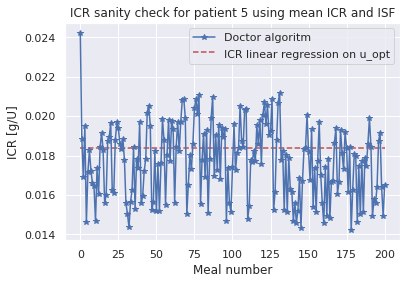

In [19]:
## Plot of ICR
plt.figure()
plt.plot(ICR_all,'*-', label = 'Doctor algoritm')
plt.hlines(true_ICR, 0, nMeals, label='ICR linear regression on u_opt', colors = 'r', linestyles='--')
plt.legend()
plt.title(f'ICR sanity check for patient {patientNr} using mean ICR and ISF')
plt.xlabel('Meal number')
plt.ylabel('ICR [g/U]')
plt.savefig('figures/doctor_ICR_ISF_mean.pdf', bbox_inches="tight")
plt.show()

In [5]:
patientNr = 132
patient = Sim.Patient(patientNr, ISF=all_ISF[patientNr])
patient.steadyState() # compute the basal insulin and steady-state 

path_to_u_opt = 'simulations/calculate_u_opt/data/'
patient.set_u_opt(path_to_u_opt=path_to_u_opt)
patient.estimate_ICR(patient.u_opt[-75:],patient.u_opt_meal_range[-75:])
ICR_0 = patient.ICR.copy()

In [6]:
ICR_0

0.04747534505908509

In [27]:
## Let's examine the doctor update for these quantiles

patientNrs = (100, 751, 851, 338, 42)

patient = Sim.Patient(patientNr, ISF=all_ISF[patientNr])

patient.steadyState() # compute the basal insulin and steady-state 


In [28]:
nMeals = 200
ICR_all = np.zeros((nMeals+1, len(patientNrs)))
ICR_all[0,:] = ICR_0


for i, patientNr in enumerate(patientNrs):
    patient = Sim.Patient(patientNr, ISF=all_ISF[patientNr])
    patient.steadyState()
    patient.ICR = ICR_0

    for j in tqdm(range(nMeals)):
        np.random.seed(int(j+75))

        Meal = np.random.uniform(5,20, size = (1,1))

        Bolus = Meal/patient.ICR

        patient.simulate(Bolus,Meal,x0 = patient.xSS, kappa = 100)
        
        # Now fix the doctor update formula
        e = (patient.CGM[-1] - patient.target)/patient.ISF * 200# Convert to correct units mU/min! 1000/5
        # correctBolus = Bolus + e 
        #patient.ICR = (Meal / correctBolus).item()
        patient.ICR = ((Meal * patient.ICR)/(patient.ICR * e + Meal)).item()

        ICR_all[j+1,i] = patient.ICR

100%|██████████| 200/200 [00:26<00:00,  7.45it/s]


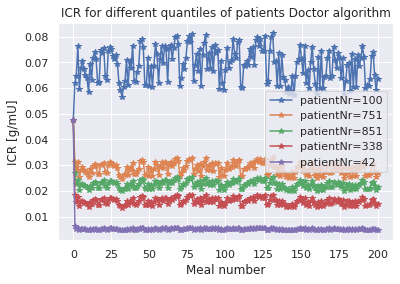

In [32]:
#### Make a short plot showing all of this.... 

plt.figure()

for i, patientNr in enumerate(patientNrs):
    plt.plot(ICR_all[:,i], '*-', label = f'patientNr={patientNr}')

plt.ylabel('ICR [g/mU]')
plt.xlabel('Meal number')
plt.title('ICR for different quantiles of patients Doctor algorithm')
plt.legend()
plt.savefig('figures/Doctor_guess.pdf', dpi = 150)
plt.show()